In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from astropy.visualization import ZScaleInterval
import matplotlib

%matplotlib inline

In [2]:
#wisps.POLYNOMIAL_RELATIONS

In [3]:
df=wisps.datasets['candidates']

In [4]:
#wisps.POLYNOMIAL_RELATIONS

In [5]:
df=df[df.spt.apply(splat.typeToNum)>19.0]

In [6]:
df['spectra']=df.grism_id.apply(lambda x: wisps.Source(name=x))

In [7]:
df['spt']=df['spectra'].apply(lambda x: x.spt)

In [8]:
df=df.sort_values(by='spt').reset_index(drop=True)

In [9]:
def plot_image(sp, ax, cmap='inferno'):
     # mapping between filters and images
    image_data_dict={'F140W' : sp.photo_image.f140,
                'F160W': sp.photo_image.f160,
                'F110W': sp.photo_image.f110}
    try:
        image_key_to_use=[ k for k in image_data_dict.keys() if image_data_dict[k]['grid'] is not None  ][0]
    except:
        image_key_to_use='F140W'

    
    mag_in_filter=np.round(sp.mags[image_key_to_use][0])
    image_data=image_data_dict[image_key_to_use]
    
    image=image_data['data']
    
    mask=image<3.*np.nanstd(image)
    vmin, vmax=ZScaleInterval().get_limits( image[mask])
    #norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
    norm=LogNorm()
    
    ax.pcolormesh(image_data['grid'][0], image_data['grid'][1], 
                   image_data['data'], cmap=cmap,
                   vmin=vmin, vmax=vmax, rasterized=True, alpha=1.0)
    
    ax.plot(image_data['center'][0], 
             image_data['center'][1], marker='+',c='#111111', ms=30)

In [10]:
from matplotlib import gridspec
from matplotlib.colors import LogNorm

In [58]:
gs = gridspec.GridSpec(len(df), 3,width_ratios=[2., .4, 2.])

In [59]:
10*1.5

15.0

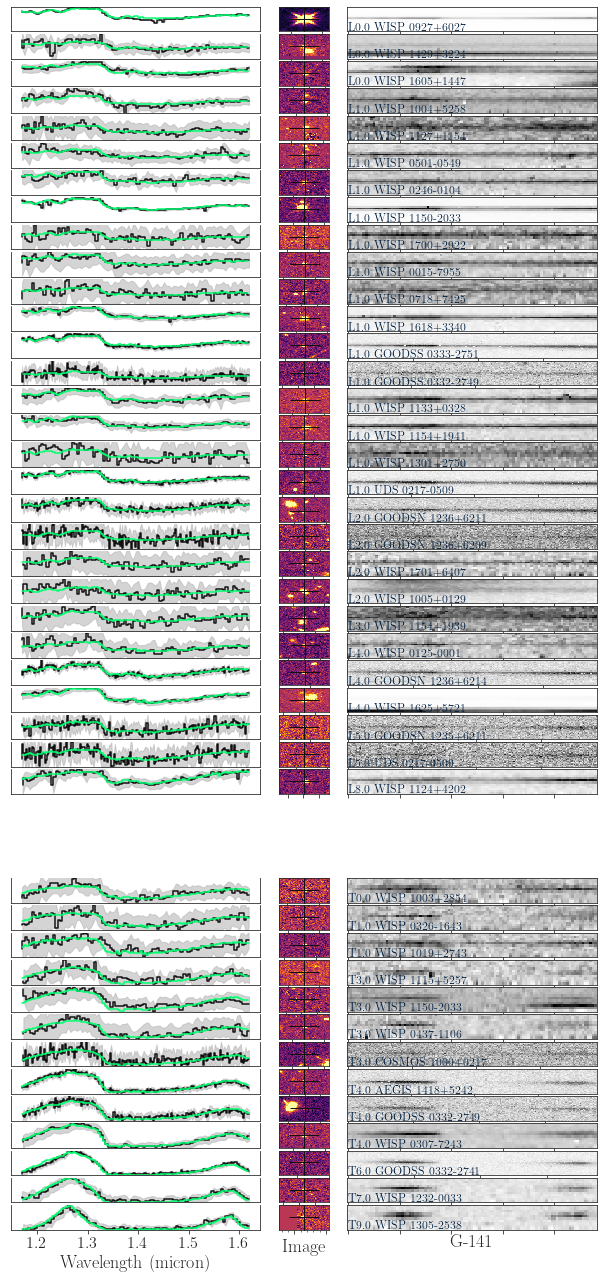

In [60]:
#fig, ax=plt.subplots(nrows=len(df),ncols=3,  width_ratios=[3, 1, 3], figsize=(8*1.5, 8*1.5), sharex=False, sharey=False)

fig = plt.figure(figsize=(7*1.5, 15*1.5)) 

for idx, row in df.iterrows():
 s=row.spectra
 if splat.typeToNum(s.spt)> 19:
    s.normalize(waverange=[1.17,1.62])
    std=splat.STDS_DWARF_SPEX[s.spt]
    std.normalize(waverange=[1.17,1.62])
    #s.normalize()
    mask=np.where((s.wave>1.17) & (s.wave<1.62))[0]
    mask2=np.where((std.wave.value>1.17) & (std.wave.value<1.62))[0]
    a=None
    
    #print (idx)
    a=plt.subplot(gs[idx, 0])
    
    
    
    a.step(s.wave[mask], s.flux[mask], color='#111111')
    un, sc=splat.compareSpectra(s.splat_spectrum, std, fit_range=[1.15, 1.65])
    std.scale(sc)
    a.step(std.wave[mask2], std.flux[mask2],color='#01FF70' )
    
    a.fill_between(s.wave[mask],s.flux[mask]-3.*s.noise[mask], \
                   s.flux[mask]+3.*s.noise[mask], alpha=.5,color='#AAAAAA')
    
    b=plt.subplot(gs[idx, 2])
    b.imshow(s.spectrum_image.T[mask].T, cmap='Greys', interpolation='nearest')
    b.set_aspect('auto')
    
    c=plt.subplot(gs[idx,1])
    
    plot_image(s, c)
    a.set_ylim([0., np.nanmax(s.flux[mask])])
   
    
    if idx == 0:
        #a.spines['bottom'].set_visible(False)
        a.set_xticks([]) 
        a.set_yticks([])
        
    elif idx == len(df)-1:
        a.spines['top'].set_visible(False)
        a.set_yticks([])
        a.set_xlabel('Wavelength (micron)', fontsize=18)
        b.set_xlabel('G-141', fontsize=18)
        c.set_xlabel('Image', fontsize=18)
        
    else :
        a.spines['top'].set_visible(False)
        #a.spines['bottom'].set_visible(False)
        a.set_xticks([]) 
        a.set_yticks([])
        
    if row.spt.lower().startswith('t'): b.text(0.0,s.spectrum_image.shape[0]-1,row.spt +' '+ s.shortname, fontsize=12, color='#001f3f')
    if row.spt.lower().startswith('l') or row.spt.lower().startswith('m'): 
        b.text(0.0, s.spectrum_image.shape[0]-1,row.spt +' '+ s.shortname, fontsize=12, color='#001f3f')
        
    b.set_yticks([])
    b.tick_params(labelbottom=False)
    
    c.set_yticks([])
    c.tick_params(labelbottom=False)



plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
plt.minorticks_on()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidates.pdf')

In [14]:
df['distance']=df.spectra.apply(lambda x: x.distance['val'].value)

In [15]:
#df['distance']

In [16]:
fdf=df

In [17]:
fdf.drop(['spectra', 'exposure'], axis=1).to_latex(wisps.LIBRARIES+'/candidates2.tex', index=False, na_rep=' ' )

In [18]:
#distance distributions
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import astropy.units as u
coords=SkyCoord(ra=fdf.RA.values*u.deg, dec=fdf.DEC.values*u.deg, distance=fdf.distance.values*u.pc)#.transform_to(coord.Galactocentric) 

In [19]:
x, y, z=coords.cartesian.xyz

In [20]:
r=np.sqrt(x**2+y**2)

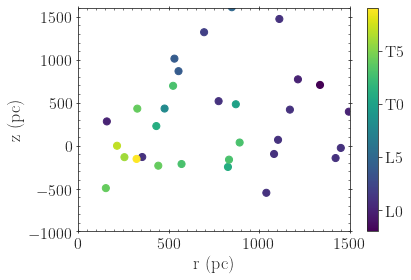

In [21]:
fig, ax=plt.subplots(figsize=(6, 4))
sc=plt.scatter(r, z, c=fdf.spt.apply(splat.typeToNum), cmap='viridis', s=50)
br=plt.colorbar(sc)
plt.ylabel('z (pc)', fontsize=18)
plt.xlabel('r (pc)', fontsize=18)
ax.set_xticks(np.arange(0, 2000, 50), minor=True)
ax.set_yticks(np.arange(-1000, 2500, 100), minor=True)

ax.set_xlim([0, 1500])
ax.set_ylim([-1000, 1600])

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.tick_params(which='major',direction='inout')
ax.tick_params(which='minor', direction='in')

br.set_ticks([20, 25, 30, 35, 40])
br.set_ticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_distances.pdf')

In [22]:
mags=wisps.Annotator.reformat_table(pd.DataFrame.from_records(df.spectra.apply(lambda x: x.mags).values))

In [23]:
#mags

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


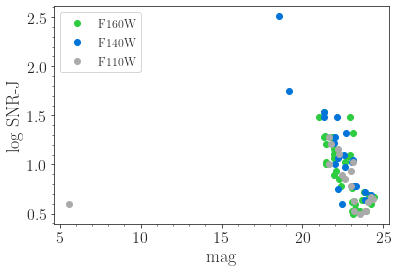

In [24]:
import seaborn as sns
fig, ax=plt.subplots(figsize=(6, 4))
ax.errorbar(mags.F160W,  fdf.snr1.apply(np.log10),fmt='o', color='#2ECC40', label='F160W' )
ax.errorbar(mags.F140W,   fdf.snr1.apply(np.log10),fmt='o', color='#0074D9', label='F140W')
ax.errorbar(mags.F110W,   fdf.snr1.apply(np.log10),fmt='o', color='#AAAAAA' , label='F110W')
#plt.xlabel('mag', fontsize=16)

plt.minorticks_on()
#ax.yaxis.set_ticks_position('both')
#ax.xaxis.set_ticks_position('both')
#ax.tick_params(which='major',direction='inout')
#ax.tick_params(which='minor', direction='in')

plt.legend()

plt.xlabel('mag', fontsize=18)
plt.ylabel('log SNR-J', fontsize=18)
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_distribution_candidates.pdf')

In [25]:
dhgjk=fdf.sort_values(by='distance')[['grism_id', 'distance', 'spt']]

In [26]:
finalfinaldf=wisps.Annotator.reformat_table(wisps.datasets['stars'][wisps.datasets['stars'].grism_id.isin(fdf.grism_id)])

In [27]:
#\tablehead{\colhead{Short Name} & 
#           \nocolhead{Grism ID} & \colhead{SNR-J} & \colhead{SpT} &\nocolhead{RA }& 
#           \nocolhead{DEC} &  \nocolhead{F110W}& \nocolhead{F110Wer} &  
#           \nocolhead{F140W} &  \nocolhead{F140Wer} & 
#           \colhead{F160W} &\nocolhead{F160Wer } &\colhead{Distance (pc)} & 
#           \nocolhead{Distance error} }

In [28]:
int(round(fdf.spectra.iloc[0].snr['snr1']))

324

In [29]:
latc_df=pd.DataFrame()

In [30]:
latc_df['Shortname']=fdf.spectra.apply(lambda x: x.shortname.upper())
latc_df['grism id']=fdf.spectra.apply(lambda x: x.name.upper())
latc_df['snrj']=fdf.spectra.apply(lambda x: int(round(x.snr['snr1'])))
latc_df['spt']=fdf.spectra.apply(lambda x: x.spt.upper().replace('.0', ''))
latc_df['ra']=fdf.spectra.apply(lambda x: x.ra.value)
latc_df['dec']=fdf.spectra.apply(lambda x: x.dec.value)
latc_df['f110']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][0], 1))
latc_df['f110_er']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][1], 1))
latc_df['f140']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][0],1))
latc_df['f140_er']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][1], 1))
latc_df['f160']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][0], 1))
latc_df['f160_er']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][1], 1))
latc_df['distance']=fdf.spectra.apply(lambda x: int(round(x.distance['val'].value)))
latc_df['distance_er']=fdf.spectra.apply(lambda x: int(round(x.distance['er'].value)))



In [31]:
latc_df=latc_df[latc_df.spt.apply(splat.typeToNum)> 19.]

In [32]:
latc_df

,Shortname,grism id,snrj,spt,ra,dec,f110,f110_er,f140,f140_er,f160,f160_er,distance,distance_er
0,WISP 0927+6027,PAR21-00005,324,L0,141.989319,60.462970,NaN,NaN,18.6,0.0,NaN,NaN,323,7
1,WISP 1429+3224,PAR378-00052,8,L0,217.333206,32.416400,22.4,0.0,NaN,NaN,21.9,0.0,1439,530
2,WISP 1605+1447,PAR240-00040,17,L0,241.256699,14.783400,NaN,NaN,22.0,0.0,NaN,NaN,1547,33
3,WISP 1004+5258,PAR438-00051,10,L1,151.204559,52.974800,NaN,NaN,22.6,0.0,NaN,NaN,1846,33
4,WISP 1127+1154,PAR416-00101,4,L1,171.892029,11.916600,23.2,0.0,NaN,NaN,23.2,0.1,2135,1045
5,WISP 0501-0549,PAR461-00070,7,L1,75.285141,-5.825590,22.6,0.0,NaN,NaN,22.2,0.0,1430,590
6,WISP 0246-0104,PAR483-00077,9,L1,41.721233,-1.079250,23.0,0.0,NaN,NaN,22.1,0.0,1451,441
7,WISP 1150-2033,PAR199-00009,57,L1,177.706833,-20.561000,NaN,NaN,19.2,0.0,NaN,NaN,379,7
8,WISP 1700+2922,PAR137-00128,4,L1,255.171310,29.373300,NaN,NaN,NaN,NaN,23.3,0.0,3262,55
9,WISP 0015-7955,PAR244-00072,6,L1,3.785810,-79.930220,NaN,NaN,22.2,0.0,NaN,NaN,1528,27


In [33]:
len(latc_df[latc_df.spt.str.startswith('T')]), len(latc_df[latc_df.spt.str.startswith('L')])

(13, 29)

In [34]:
latc_df.to_latex(wisps.LIBRARIES+'/candidates.tex',
             header=True, index=False, na_rep=' ')

In [35]:
%%capture 
fold='/Users/caganze/research/wisps/figures/ltwarfs/'

ids=0
for idx, row in df.iterrows():
    s=row.spectra
    
    if splat.typeToNum(s.spt)> 19:
        filename=fold+'spectrum'+str(ids)+'.jpeg'
        s.plot(save=True, filename=filename)
        ids=ids+1

In [36]:
from astropy.coordinates import SkyCoord

In [37]:
import astropy.units as u

In [38]:
#latc_df.ra.values*u.deg

In [39]:
sk=SkyCoord(ra=latc_df.ra.values*u.deg, dec=latc_df.dec.values*u.deg, distance=latc_df.distance.values*u.pc)

In [40]:
norm = matplotlib.colors.Normalize(vmin=20., vmax=37.0)

In [41]:
from matplotlib import cm

In [42]:
#cm.viridis[latc_df.spt.apply(splat.typeToNum).values]

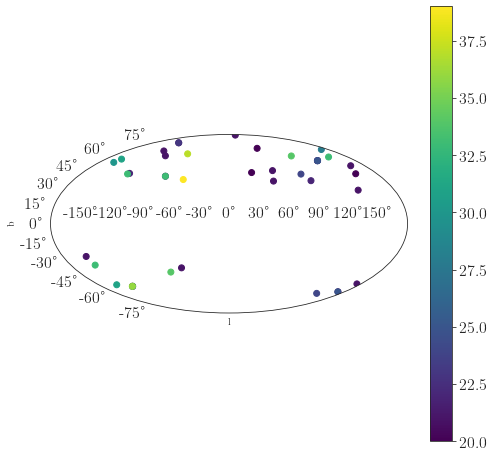

In [43]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='mollweide')
c=ax.scatter(sk.galactic.l.wrap_at(180*u.deg).radian, sk.galactic.b.wrap_at(180*u.deg).radian,
           c=latc_df.spt.apply(splat.typeToNum).values, cmap='viridis')
plt.xlabel("l")
plt.ylabel("b")
plt.colorbar(c)

In [44]:
stars=wisps.Annotator.reformat_table(pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='stars'))

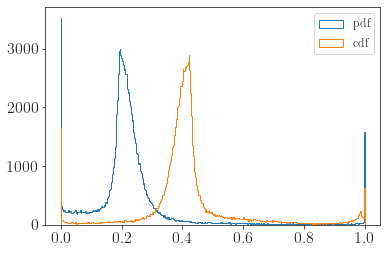

In [45]:
h=plt.hist(stars.f_test.values, label='pdf', bins='auto', histtype='step')
h=plt.hist(stars.f_test_cdf.values, label='cdf', bins='auto', histtype='step')
plt.legend()

In [47]:
df.spectra.iloc[0].mags

{'F110W': (nan, nan), 'F160W': (nan, nan), 'F140W': (18.562, 0.002)}

In [48]:
wisps.POLYNOMIAL_RELATIONS

{'snr_F110W': poly1d([-0.24733259,  6.62827215]),
 'snr_F140W': poly1d([-0.2671465,  7.098545 ]),
 'snr_F160W': poly1d([-0.24944873,  6.68969987]),
 'sp_F110W': poly1d([-3.17452276e-06,  5.08637834e-04, -3.34269782e-02,  1.15206906e+00,
        -2.19517527e+01,  2.19597212e+02, -8.91384270e+02]),
 'sigma_log_f110': 0.42819868018721347,
 'sigma_log_f140': 0.4668121918409931,
 'sigma_log_f160': 0.4525423819285358,
 'sp_F140W': poly1d([ 3.49700571e-06, -5.38160346e-04,  3.39775057e-02, -1.12587153e+00,
         2.06379050e+01, -1.98034222e+02,  7.85333071e+02]),
 'sp_F160W': poly1d([ 2.95894023e-06, -4.55984286e-04,  2.88289790e-02, -9.56244494e-01,
         1.75370703e+01, -1.68252334e+02,  6.67704101e+02])}

In [49]:
#transform dupuy relation into HST mags
def get_colors(spt, flt):
    #using splat filtermag
    sp = splat.STDS_DWARF_SPEX[spt]
    sp.fluxCalibrate('2MASS J',float(sp.j_2mass))
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    magj, mag_uncj = splat.filterMag(sp,'2MASS J')
    magh, mag_unch = splat.filterMag(sp,'2MASS H')
    #calculate the offset between HST filters and 2mass filters but add the uncertainty
    
    magjtouse=np.random.normal(magj,  mag_uncj)
    maghtouse=np.random.normal(magh,  mag_unch)
    offsetj=magjtouse-mag
    offseth=maghtouse-mag
    return [offsetj, offseth]

In [51]:
from tqdm import tqdm

In [53]:
sp_grid=np.arange(20, 40)

In [54]:
colors=[]
absmags=[]
fltrs= ['NICMOS {}'.format(k) for k in ['F110W', 'F140W', 'F160W']]
for x in tqdm(sp_grid):
    c=[]
    for flt in fltrs:
        color=get_colors(splat.typeToNum(x), flt)
        c.append(color)
    colors.append(c)
#abs_hstmags=[get_abs_hst_mag(splat.typeToNum(x)) for x in  sp_

100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


In [55]:
colors=np.array(colors)

In [83]:
colors_dict=dict(zip(sp_grid, colors))

In [119]:
#olors_dict

In [109]:
js=[]
hs=[]
for s in tqdm(df['spectra'].values):
    try:
        mags=s.mags

        corr=colors_dict[splat.typeToNum(s.spt)]
        
        j_f110=mags['F110W']+corr[0][0]
        h_f110=mags['F110W']+corr[0][1]

        j_f140=mags['F140W']+corr[1][0]
        h_f140=mags['F140W']+corr[1][1]

        j_f160=mags['F160W']+corr[2][0]
        h_f160=mags['F160W']+corr[2][1]



        js.append([np.nanmedian([j_f110, j_f140, j_f160]), np.nanstd([j_f110, j_f140, j_f160])])
        hs.append([np.nanmedian([h_f110, h_f140, h_f160]), np.nanstd([h_f110, h_f140, h_f160])])
        
    except KeyError:
        pass

    

100%|██████████| 45/45 [00:00<00:00, 1743.04it/s]


In [110]:
js=np.array(js)
hs=np.array(hs)

In [111]:
spex=splat.searchLibrary()

([<matplotlib.lines.Line2D at 0x1c343ab1d0>,
  <matplotlib.lines.Line2D at 0x1c343ca240>])

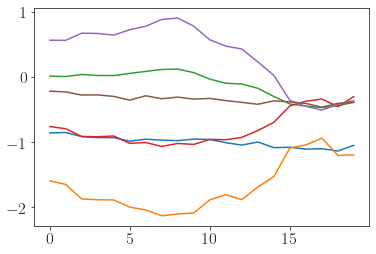

In [117]:
plt.plot(colors[:,0]), plt.plot(colors[:,1]), plt.plot(colors[:,2])

Text(0.5, 0, 'J-H')

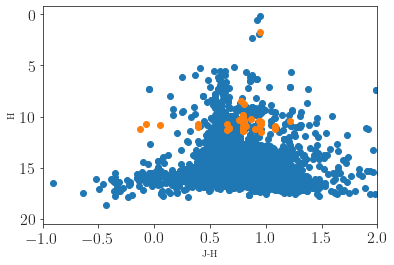

In [113]:
fig, ax=plt.subplots()
ax.scatter( spex.J_2MASS.values-spex.H_2MASS.values, spex.J_2MASS.values)
ax.scatter(js[:, 0]-hs[:,0], hs[:, 0])
ax.invert_yaxis()
ax.set_xlim([-1, 2])
ax.set_ylabel("H")
ax.set_xlabel("J-H" )